<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%ED%95%98%EC%88%9C%ED%9A%8C/Lab4_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from typing import List

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers

tfds.disable_progress_bar()
keras.utils.set_random_seed(42)

In [24]:
# Model
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0

# Training
NUM_EPOCHS = 20
BASE_LR = 0.001
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5

In [14]:
def preprocess_dataset(is_training=True):
    def fn(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random crops.
            image = float(image) / 255.0
            image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            image = tf.image.random_crop(image, (IMAGE_SIZE, IMAGE_SIZE, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = float(image) / 255.0
            image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label

    return fn


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=AUTO)
    return dataset.batch(BATCH_SIZE).prefetch(AUTO)


train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]",], as_supervised=True
)
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()

print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")


train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)


Number of training examples: 3303
Number of validation examples: 367


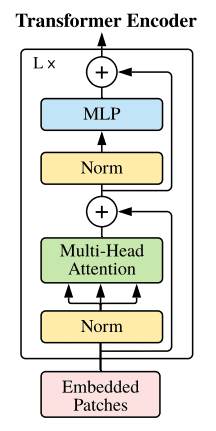

In [15]:
def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and add Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 2 if "deit" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Implement here
    # Layer normalization 1 - layers.LayerNormalization(epsilon)
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer - layers.MultiHeadAttention(num_heads, key_dim, dropout)
    x2 = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)

    # Skip connection
    # layers.add()
    x3 = layers.add([x2, encoded_patches])

    # Layer normalization 2
    x4 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x3)

    # MLP layer 1.
    x5 = mlp(
        x4,
        dropout_rate=DROPOUT_RATE,
        hidden_units=MLP_UNITS,
    )

    # Skip connection 2.
    outputs = layers.add([x5, x2])

    return keras.Model(encoded_patches, outputs, name=name)


In [16]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
                # Implement here
                # Hint: Use convolution - What happens if kernel size is equal to stride?
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=16,
                    strides=16,
                    padding='valid',
                    name='patch_conv'
                ),
                layers.Reshape((NUM_PATCHES, PROJECTION_DIM)),

            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        self.transformer_blocks = [
            transformer(name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.

        encoded_patches = (
            self.positional_embedding + projected_patches
        )
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output


In [25]:
MODEL_TYPE = "vit"
vit_model = ViTClassifier()

lr_scaled = (BASE_LR / 51200) * BATCH_SIZE
vit_model.compile(
    optimizer=keras.optimizers.AdamW(lr_scaled, weight_decay=WEIGHT_DECAY),
    metrics=["accuracy"],
    loss='categorical_crossentropy',
)

_ = vit_model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)

Epoch 1/20
207/207 [==============================] - 100s 168ms/step - loss: 8.4462 - accuracy: 0.2389 - val_loss: 7.9493 - val_accuracy: 0.1962
Epoch 2/20
207/207 [==============================] - 33s 159ms/step - loss: 7.6303 - accuracy: 0.2455 - val_loss: 9.6256 - val_accuracy: 0.1853
Epoch 3/20
207/207 [==============================] - 32s 153ms/step - loss: 8.6807 - accuracy: 0.2386 - val_loss: 9.9728 - val_accuracy: 0.1853
Epoch 4/20
207/207 [==============================] - 32s 152ms/step - loss: 8.8982 - accuracy: 0.2371 - val_loss: 10.1891 - val_accuracy: 0.1853
Epoch 5/20
207/207 [==============================] - 32s 153ms/step - loss: 9.0407 - accuracy: 0.2371 - val_loss: 10.1363 - val_accuracy: 0.1880
Epoch 6/20
207/207 [==============================] - 32s 155ms/step - loss: 6.3743 - accuracy: 0.2050 - val_loss: 6.8957 - val_accuracy: 0.2044
Epoch 7/20
207/207 [==============================] - 32s 152ms/step - loss: 6.0419 - accuracy: 0.2031 - val_loss: 6.7637 - val

In [18]:
_ = vit_model.evaluate(val_dataset)

23/23 [==============================] - 1s 59ms/step - loss: 8.6689 - accuracy: 0.1417


In [19]:
class ViTDistilled(ViTClassifier):
    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training

        # CLS and distillation tokens, positional embedding.
        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append the tokens.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier predictions.
            return (x + x_dist) / 2

        elif training:
            # Only return separate classification predictions when training in distilled mode.
            return x, x_dist


In [26]:
class DeiT(keras.Model):
    # References:
    # https://keras.io/examples/vision/knowledge_distillation/
    # https://keras.io/examples/keras_recipes/trainer_pattern/
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        # Implement here
        # Forward pass of teacher
        # tf.nn.softmax()
        # tf.argmax() - Hard label
        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), axis=-1)
        teacher_predictions = tf.argmax(teacher_predictions, axis=-1)

        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x, training=True)

            # Compute losses - Mean of student loss and distillation loss(Hard label distillation)
            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(teacher_predictions, dist_predictions)
            loss = (student_loss + distillation_loss) / 2

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs, training=False)


In [27]:
!wget -q https://github.com/sayakpaul/deit-tf/releases/download/v0.1.0/bit_teacher_flowers.zip
!unzip -q bit_teacher_flowers.zip


In [28]:
MODEL_TYPE = "deit"
bit_teacher_flowers = keras.models.load_model("bit_teacher_flowers")

deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher=bit_teacher_flowers)

BASE_LR = 0.1

lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
    optimizer=keras.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
_ = deit_distiller.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)

Epoch 1/20
207/207 [==============================] - 184s 664ms/step - accuracy: 0.2486 - student_loss: 1.7799 - distillation_loss: 0.6960 - val_accuracy: 0.1907 - val_student_loss: 2.6807 - val_distillation_loss: 0.0000e+00
Epoch 2/20
207/207 [==============================] - 134s 650ms/step - accuracy: 0.2507 - student_loss: 1.6677 - distillation_loss: 0.5245 - val_accuracy: 0.1907 - val_student_loss: 2.6955 - val_distillation_loss: 0.0000e+00
Epoch 3/20
207/207 [==============================] - 133s 645ms/step - accuracy: 0.2507 - student_loss: 1.6613 - distillation_loss: 0.5074 - val_accuracy: 0.1907 - val_student_loss: 2.8114 - val_distillation_loss: 0.0000e+00
Epoch 4/20
207/207 [==============================] - 134s 650ms/step - accuracy: 0.2507 - student_loss: 1.6451 - distillation_loss: 0.4955 - val_accuracy: 0.1907 - val_student_loss: 2.8981 - val_distillation_loss: 0.0000e+00
Epoch 5/20
207/207 [==============================] - 133s 644ms/step - accuracy: 0.2507 - stude

In [ ]:
_ = deit_distiller.evaluate(val_dataset)